In [162]:
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import neighbors, metrics, grid_search, cross_validation

pd.set_option('display.max_rows', 30)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 30)

%matplotlib inline
plt.style.use('ggplot')

In [163]:
#df = pd.read_csv('/Users/joshuagrossman/Desktop/DS-SF-23 Final Project/Kobe/kobe_clean_forest.csv')
df = pd.read_csv('/Users/joshuagrossman/DS-SF-23-work/kobe_clean_forest.csv')

In [164]:
df.head()

,shot_id,shot_made_flag,seconds_from_period_end,loc_x,loc_y,shot_distance,action_type#Jump Shot,home_away,action_type#Layup Shot,period#3,period#2,period#1,period#4,shot_zone_range#Less Than 8 ft.,game_month#1,game_month#3,game_month#2,game_month#12,game_month#4,game_month#11,playoffs,action_type#Running Jump Shot
0,1,NaN,0.878151,0.837349,0.138922,0.227848,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,2,0.0,0.871148,0.186747,0.052695,0.189873,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2,3,1.0,0.651261,0.299197,0.214371,0.202532,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,4,0.0,0.577031,0.779116,0.262275,0.278481,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,5,1.0,0.530812,0.502008,0.052695,0.000000,0.0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0


In [165]:
df.shape

(30697, 22)

In [166]:
df.columns

Index([u'shot_id', u'shot_made_flag', u'seconds_from_period_end', u'loc_x',
       u'loc_y', u'shot_distance', u'action_type#Jump Shot', u'home_away',
       u'action_type#Layup Shot', u'period#3', u'period#2', u'period#1',
       u'period#4', u'shot_zone_range#Less Than 8 ft.', u'game_month#1',
       u'game_month#3', u'game_month#2', u'game_month#12', u'game_month#4',
       u'game_month#11', u'playoffs', u'action_type#Running Jump Shot'],
      dtype='object')

In [167]:
df.count()

shot_id                            30697
shot_made_flag                     25697
seconds_from_period_end            30697
loc_x                              30697
loc_y                              30697
shot_distance                      30697
action_type#Jump Shot              30697
home_away                          30697
action_type#Layup Shot             30697
period#3                           30697
period#2                           30697
period#1                           30697
period#4                           30697
shot_zone_range#Less Than 8 ft.    30697
game_month#1                       30697
game_month#3                       30697
game_month#2                       30697
game_month#12                      30697
game_month#4                       30697
game_month#11                      30697
playoffs                           30697
action_type#Running Jump Shot      30697
dtype: int64

In [168]:
#Create a new df (df2) based on the blanks in the shot_made_flag
#This ceates a new DF of all the records where shot_made_flag is not null
df2 = df[df.shot_made_flag.notnull()]

In [169]:
df2.shape

(25697, 22)

In [170]:
#You'll still need to reserve the 5,000 blank records for submitting to Kaggle
df_testing = df[df.shot_made_flag.isnull()]

In [171]:
#Splitting the dataset into train and test
#60% of the dataset to train the model; the rest to test the model

train_df = df2.sample(frac = .6, random_state = 0).sort_index()

train_df.shape

(15418, 22)

In [172]:
test_df = df2.drop(train_df.index)

test_df.shape

(10279, 22)

In [173]:
#Try a few different KNN models with different features based on the random forest features from the kobe-clean-dataset-v5
#train_x = train_df[ ['shot_distance' ] ]
#train_x = train_df[ ['seconds_from_period_end', 'loc_x', 'loc_y', 'shot_distance' ] ]
train_X = train_df[ ['seconds_from_period_end', 'loc_x', 'loc_y' ] ]
#train_X = train_df[ ['seconds_from_period_end', 'loc_y', 'shot_distance' ] ]
train_y = train_df.shot_made_flag

model = neighbors.KNeighborsClassifier(n_neighbors = 5, weights = 'distance')
model.fit(train_X, train_y)
print 'train = ', model.score(train_X, train_y)

test_X = test_df[ ['seconds_from_period_end', 'loc_x', 'loc_y'] ]
#test_X = train_df[ ['seconds_from_period_end', 'loc_y', 'shot_distance' ] ]
test_y = test_df.shot_made_flag

print 'test  = ', model.score(test_X, test_y)

train =  0.952977039824
test  =  0.543924506275


In [174]:
#Validation & finding the best k
#This can take a minute or two to run
k = range(1, 160)

score_df = pd.DataFrame({'k': k})

models = score_df.\
    apply(lambda row: neighbors.KNeighborsClassifier(n_neighbors = row['k']).fit(train_X, train_y), axis = 1)

score_df['TrainScore'] = models.apply(lambda model: model.score(train_X, train_y))
score_df['TestScore'] = models.apply(lambda model: model.score(test_X, test_y))

In [175]:
score_df

,k,TrainScore,TestScore
0,1,0.941951,0.524370
1,2,0.739720,0.558517
2,3,0.753794,0.546065
3,4,0.700415,0.562020
4,5,0.704436,0.554237
5,6,0.679660,0.563868
6,7,0.681736,0.559004
7,8,0.666364,0.572916
8,9,0.668375,0.564355
9,10,0.656700,0.572916


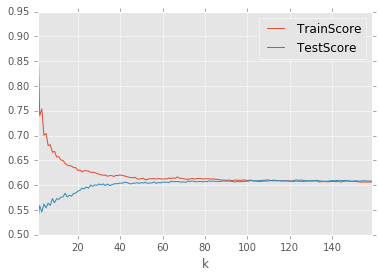

In [176]:
score_df.set_index('k').plot()

In [177]:
#Cross-Validation
#10-fold cross-validation to choose the most efficient k
#This can take a minute or two to run

k_cv = 10 # 10-fold CV
sq_len = 160
k_nn = range(1, sq_len * (k_cv - 1) / k_cv) # k-NN

gs = grid_search.GridSearchCV(
    estimator = neighbors.KNeighborsClassifier(),
    param_grid = {'n_neighbors': k_nn},
    cv = cross_validation.KFold(sq_len, n_folds = k_cv)
)

gs.fit(X, y)

score_df = pd.DataFrame({'k': [score.parameters['n_neighbors'] for score in gs.grid_scores_],
    'Score': [score.mean_validation_score for score in gs.grid_scores_]})

#tip: try using the sqrt of the number k = sqrt of len(df)

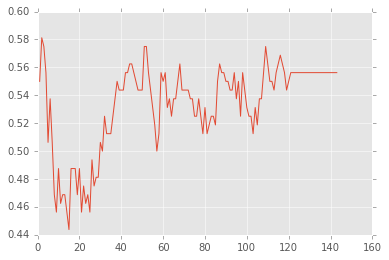

In [178]:
plt.plot(score_df.k, score_df.Score)

In [179]:
#Finding the most effecient k
score_df[score_df.Score == score_df.Score.max()]

,Score,k
1,0.58125,2


In [180]:
#Grid search score
gs.score(test_X, test_y)

0.72516781788111684